## Dissertation Project - News Summary Dissertation [100 marks]

### Motivation 

> 1. Provide tools for anyone needing to speed up their research process
> 2. Providing ways for user to quickly determine whether a piece of research is beneficial for their specific search terms




### Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
import random
from tqdm.notebook import tqdm

import numpy as np 
import pandas as pd
import math

import json

DATASET = "./Dataset/"

Detect which device (CPU/GPU) to use.

In [2]:
seed = 0
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed) 
torch.cuda.manual_seed_all(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Overview

Summarisation model
> 1. Dataset preprocessing
> 2. Dataloader
> 3. RNN model definition
> 4. Model training
> 5. Model prediction evaluation
> 6. Dataset Exploration
> 7. Dataset modification/Data Augmentation
> 8. Model improvement
> 9. Model finalisation and evaluation

Paper querying
> 1. Attention on query (Return usefulness percentage
> 2. Evaluate performance


# Data preprocessing

In [5]:
# Comment this block if dataset is reorganised
DATA_DIR = "SSN/papers.SSN.jsonl"
dataset_path = DATASET+DATA_DIR
with open(dataset_path) as f:
    lines = f.read().splitlines()
df_inter = pd.DataFrame(lines)
df_inter.columns = ['json_element']
df_final = pd.json_normalize(df_inter['json_element'].apply(json.loads))
df_final.to_json("./Dataset/SSN/SSN_Dataset.json")
df_final

KeyboardInterrupt: 

In [ ]:
for i,summary in df_final.iterrows():
    temp = summary["abstract"]
    print(type(summary["abstract"]))
    break

In [28]:
#Comment this block if dataset is shortened
DATA_DIR = "SSN/SSN_Dataset.json"
dataset_path = DATASET+DATA_DIR
df = pd.read_json(dataset_path)
df

,paper_id,title,abstract,section_names,domain,text
0,4650265,XGBoost: A Scalable Tree Boosting System,[tree boosting is a highly effective and widel...,"[introduction, tree boosting in a nutshell, re...",[],[[machine learning and data - driven approache...
1,9195903,Robust Face Alignment Using a Mixture of Invar...,"[face alignment , which is the task of finding...","[introduction, previous work, our approach, su...",[Computer science],[[face alignment refers to finding the pixel l...
2,119332442,Modulation instability associated nonlinear dy...,[we study pattern - forming nonlinear dynamics...,"[introduction, modulation instability of becs ...",[Physics],[[modulation instability ( mi ) is one of the ...
3,13494452,Free evolution on algebras with two states,[the key result in the paper concerns two tran...,"[introduction, preliminaries, polynomials and ...",[Mathematics],[[in a series of papers belinschi and nica int...
4,119269876,Light Dilaton at Fixed Points and Ultra Light ...,[we investigate the infrared dynamics of a non...,"[introduction, a comment on the large nn and n...",[Physics],[[understanding strong dynamics constitutes a ...
...,...,...,...,...,...,...
140794,12157610,Minimal and Maximal Operator Spaces and Operat...,[we examine k - minimal and k - maximal operat...,"[introduction, quantum information theory prel...",[Mathematics],[[a primary goal of this paper is to formally ...
140795,14690185,AN OBSTRUCTION TO ASYMPTOTIC SEMISTABILITY AND...,"[in this paper , we consider an obstruction to...","[introduction, statement of results, an obstru...",[Mathematics],[[for a polarized algebraic manifold inlinefor...
140796,15296646,Direct Detection of Neutralino Dark Matter and...,[we compare predictions for the spin - indepen...,"[introduction, msugra, more general models, co...",[Physics],[[the minimal supersymmetric standard model ( ...
140797,119576690,PCA by Optimisation of Symmetric Functions has...,[principal component analysis ( pca ) finds th...,"[introduction, pca by determinant optimisation...",[Mathematics],"[[let inlineform0 be a data matrix , with rows..."


In [32]:
df.iloc[140794]["section_names"]

['introduction',
 'quantum information theory preliminaries',
 'kk-minimal and kk-maximal operator spaces',
 'kk-super minimal and kk-super maximal operator systems',
 'norms on operator systems',
 'contractive maps as separability criteria']

Function to return index for conclusion section

In [12]:
def trim_index(row):
    return [row.index(x)+1 for x in row if x.startswith('conclusion') or x.startswith("summar")]

In [13]:
def trim_text(text, index):
    return text[0:index]

In [14]:
# Comment this block if dataset is shortened
# Trim text after conclusion
indexes = []
for i, row in df.iterrows():
    section = row["section_names"]
    #print(section)
    index = trim_index(section)
    #print(index)
    if not index:
        indexes.append(i)
    # if section can be filtered
    else:
        index = index[0]
        abstract = row["abstract"]
        text = row["text"]
        section = row["section_names"]
        df.at[i, "section_names"] = trim_text(section, index)
        df.at[i, "abstract"] = trim_text(abstract, index)
        df.at[i, "text"] = trim_text(text, index)
# dropping rows in dataframe that can't easily filter out reference section
print(len(indexes))
df.drop(indexes, inplace=True)
df.to_json("./Dataset/SSN/SSN_Dataset_Short.json")

49413


35% of paper will be removed from the dataset due to it not having conclusion(s) and summary(ies) in their section titles, making it difficult to filter out the reference and appendix text

In [23]:
DATA_DIR = "SSN/SSN_Dataset_Short.json"
dataset_path = DATASET+DATA_DIR
df = pd.read_json(dataset_path)
df.reset_index(drop=True, inplace=True)
df

,paper_id,title,abstract,section_names,domain,text
0,4650265,XGBoost: A Scalable Tree Boosting System,[tree boosting is a highly effective and widel...,"[introduction, tree boosting in a nutshell, re...",[],[[machine learning and data - driven approache...
1,9195903,Robust Face Alignment Using a Mixture of Invar...,"[face alignment , which is the task of finding...","[introduction, previous work, our approach, su...",[Computer science],[[face alignment refers to finding the pixel l...
2,119332442,Modulation instability associated nonlinear dy...,[we study pattern - forming nonlinear dynamics...,"[introduction, modulation instability of becs ...",[Physics],[[modulation instability ( mi ) is one of the ...
3,119269876,Light Dilaton at Fixed Points and Ultra Light ...,[we investigate the infrared dynamics of a non...,"[introduction, a comment on the large nn and n...",[Physics],[[understanding strong dynamics constitutes a ...
4,59413881,Decoder-tailored Polar Code Design Using the G...,[we propose a new framework for constructing p...,"[introduction, polar codes, polar code constru...","[Computer science, Mathematics]",[[polar codes are the first family of codes ...
...,...,...,...,...,...,...
91381,1520660,Dirichlet Process Mixtures of Generalized Line...,[we propose dirichlet process mixtures of gene...,"[introduction, related work, mathematical back...","[Mathematics, Computer science]","[[in this paper , we examine the general regre..."
91382,118501110,Minimal Matter at the Large Hadron Collider,"[we classify all possible new u(1 ) x su(2 ), ...","[introduction, new matter and its production, ...",[Physics],[[the higgs mass hierarchy puzzle suggests new...
91383,16180248,On simulations of the classical harmonic oscil...,[we show that any second order linear ordinary...,"[introduction, simplest discretizations of the...","[Physics, Mathematics]",[[the motivation for writing this paper is an ...
91384,15296646,Direct Detection of Neutralino Dark Matter and...,[we compare predictions for the spin - indepen...,"[introduction, msugra, more general models, co...",[Physics],[[the minimal supersymmetric standard model ( ...


In [24]:
summary_df = df[["abstract", "text"]]
summary_df

,abstract,text
0,[tree boosting is a highly effective and widel...,[[machine learning and data - driven approache...
1,"[face alignment , which is the task of finding...",[[face alignment refers to finding the pixel l...
2,[we study pattern - forming nonlinear dynamics...,[[modulation instability ( mi ) is one of the ...
3,[we investigate the infrared dynamics of a non...,[[understanding strong dynamics constitutes a ...
4,[we propose a new framework for constructing p...,[[polar codes are the first family of codes ...
...,...,...
91381,[we propose dirichlet process mixtures of gene...,"[[in this paper , we examine the general regre..."
91382,"[we classify all possible new u(1 ) x su(2 ), ...",[[the higgs mass hierarchy puzzle suggests new...
91383,[we show that any second order linear ordinary...,[[the motivation for writing this paper is an ...
91384,[we compare predictions for the spin - indepen...,[[the minimal supersymmetric standard model ( ...


Check if any columns contain empty values

In [17]:
summary_df.isnull().any()

abstract    False
text        False
dtype: bool

\'hi\' \ is used for space <br>
random space, which is used for reference [15] quote box <br>
sec ref is hyperlink to a section <br>
fig ref is hyperlink to a figure <br>
inlineform <br>
displayform are both symbols, both contains numbers in string <br>
remove all forms and remove all symbols but keep numbers <br>

In [25]:
def contain_let(string):
    return any(char.isalpha() for char in string)

In [26]:
def contain_num(string):
    return any(char.isdigit() for char in string)

In [31]:
def cleanLine(line, text=False):
    "Text parameter is to indicate whether the line is from text or abstract"
    alphabet = list(string.ascii_lowercase)
    number = list(map(str, range(10)))
    symbols = ["'", "’"]
    valid_char = alphabet + number + symbols
    stop_words = list(ENGLISH_STOP_WORDS)
    
    clean_line = line.lower()
    clean_line = clean_line.strip()
    
    # fix apostrophes in line by removing apostrophe with no following alphabet character
    clean_line = clean_line.replace("' ", " ")
    if clean_line and clean_line[-1] == "'":
        clean_line = clean_line[0:len(clean_line)-1]
    # fix apostrophes in line by removing space before single quote
    clean_line = clean_line.replace(" '", "'")
    #remove punctuation
    # replace all non alphabet character with space
    difference = list(set(clean_line).symmetric_difference(valid_char))

    for dif in difference:
        clean_line = clean_line.replace(dif, " ")
    
    # clean line = clean line remove forms
    words = clean_line.split()

    #  remove forms
    words = [x.replace(x, "") if contain_let(x) and contain_num(x) else x for x in words]
    # remove empty strings
    words = filter(None, words)

    # stop words from sklearn, remove stop words
    if text:
        words = [x for x in words if not x in stop_words]

    # combine the items into 1 string
    clean_line = ' '.join(words)
    return clean_line

In [32]:
def concatParagraph(paragraph, text):
    clean_paragraph = ""
    for line in paragraph:
        lines = cleanLine(line)
        clean_paragraph += cleanLine(lines, text) + " "
        #print(clean_paragraph)
        
    return(clean_paragraph.strip())

In [33]:
def concatPaper(paper, text):
    clean_paper = ""
    for paragraph in paper:
        clean_paper += concatParagraph(paragraph, text) + " "
    return(clean_paper.strip())

In [34]:
for i, row in tqdm(summary_df.iterrows(), total=df.shape[0]):
    abstract = row["abstract"]
    paper = row["text"]
    
    summary_df.at[i, "abstract"] = concatParagraph(abstract, text=False)
    summary_df.at[i, "text"] = concatPaper(paper, text=False)

  0%|          | 0/91386 [00:00<?, ?it/s]

In [35]:
summary_df.to_json("./Dataset/SSN/SSN_Dataset_Short_Clean_NoStop.json")
summary_df

,abstract,text
0,tree boosting is a highly effective and widely...,machine learning and data driven approaches ar...
1,face alignment which is the task of finding th...,face alignment refers to finding the pixel loc...
2,we study pattern forming nonlinear dynamics st...,modulation instability mi is one of the most f...
3,we investigate the infrared dynamics of a nons...,understanding strong dynamics constitutes a co...
4,we propose a new framework for constructing po...,polar codes are the first family of codes prov...
...,...,...
91381,we propose dirichlet process mixtures of gener...,in this paper we examine the general regressio...
91382,we classify all possible new u 1 x su 2 x su 3...,the higgs mass hierarchy puzzle suggests new p...
91383,we show that any second order linear ordinary ...,the motivation for writing this paper is an ob...
91384,we compare predictions for the spin independen...,the minimal supersymmetric standard model mssm...


In [36]:
DATA_DIR = "SSN/SSN_Dataset_Short_Clean_NoStop.json"
dataset_path = DATASET+DATA_DIR
df = pd.read_json(dataset_path)
df

,abstract,text
0,tree boosting is a highly effective and widely...,machine learning and data driven approaches ar...
1,face alignment which is the task of finding th...,face alignment refers to finding the pixel loc...
2,we study pattern forming nonlinear dynamics st...,modulation instability mi is one of the most f...
3,we investigate the infrared dynamics of a nons...,understanding strong dynamics constitutes a co...
4,we propose a new framework for constructing po...,polar codes are the first family of codes prov...
...,...,...
91381,we propose dirichlet process mixtures of gener...,in this paper we examine the general regressio...
91382,we classify all possible new u 1 x su 2 x su 3...,the higgs mass hierarchy puzzle suggests new p...
91383,we show that any second order linear ordinary ...,the motivation for writing this paper is an ob...
91384,we compare predictions for the spin independen...,the minimal supersymmetric standard model mssm...


In [4]:
rows = []
t_max= 1983.0
a_max=  82.0
t_min=  250.108
a_min=  20.0
for i, row in df.iterrows():
    t_word = len(row["text"].split())
    a_word = len(row["abstract"].split())
    if (t_word >= t_max or t_word <=t_min or a_word>=a_max or a_word <= a_min):
        rows.append(i)
df.drop(rows, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,abstract,text
0,study pattern forming nonlinear dynamics start...,modulation instability mi fundamental process ...
1,investigate infrared dynamics nonsupersymmetri...,understanding strong dynamics constitutes cont...
2,derive present expressions kinematic endpoints...,standard model sm particle physics enormously ...
3,compute strange quark mass m s average u d qua...,masses strange light quarks fundamental parame...
4,qcd analysis world data inclusive polarized de...,remarkable growth experimental data inclusive ...
...,...,...
29799,goal paper use multi task learning efficiently...,slot filling models useful method simple natur...
29800,consider source alice trying communicate desti...,information secrecy challenge wireless communi...
29801,propose novel deep supervised neural network t...,action recognition description videos fundamen...
29802,examine learning offensive content twitter lim...,proliferation social media millions people cur...


In [37]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<start>': 0, '<end>': 1, '<pad>':2, '<unk>':3}
        self.idx2word = {0: '<start>', 1: '<end>', 2: '<pad>', 3: '<unk>'}
        self.idx = 4

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            # this will convert each word to index and index to word as you saw in the tutorials
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]
    
    ## added function for utility
    def get_word(self,index):
        # this returns the word when given an index
        return self.idx2word[index]

    def __len__(self):
        return len(self.word2idx)


In [38]:
def build_vocab(data):
    """ 
    Parses training set token file captions and builds a Vocabulary object and dataframe for 
    the image and caption data

    Returns:
        vocab (Vocabulary): Vocabulary object containing all words appearing more than min_frequency
    """
    MIN_FREQUENCY = 0
    word_mapping = Counter()

    # for index in df.index:
    for text in tqdm(data):
        for word in text.split():
            #print(word)
            if word in word_mapping:
                word_mapping[word] += 1
            else:
                word_mapping[word] = 1

    # create a vocab instance
    vocab = Vocabulary()

    # add the words to the vocabulary
    for word in word_mapping:
        if word_mapping[word] > MIN_FREQUENCY:
            vocab.add_word(word)

    return vocab


Convert DF to text

In [21]:
text_txt = df['text']
text_txt.to_csv("text_NoStop.txt", header=False,index=False)
# write to file. 

In [36]:
vocab_model = fasttext.train_unsupervised('text_NoStop.txt', minn=2, epoch=10)
vocab_model.save_model("fastText_NoStop.bin")

In [79]:
# dir(vocab_model.get_words)
# import numpy as np
# import gc
# import sys

# def get_obj_size(obj):
#     marked = {id(obj)}
#     obj_q = [obj]
#     sz = 0

#     while obj_q:
#         sz += sum(map(sys.getsizeof, obj_q))

#         # Lookup all the object referred to by the object in obj_q.
#         # See: https://docs.python.org/3.7/library/gc.html#gc.get_referents
#         all_refr = ((id(o), o) for o in gc.get_referents(*obj_q))

#         # Filter object that are already marked.
#         # Using dict notation will prevent repeated objects.
#         new_refr = {o_id: o for o_id, o in all_refr if o_id not in marked and not isinstance(o, type)}

#         # The new obj_q will be the ones that were not marked,
#         # and we will update marked with their ids so we will
#         # not traverse them again.
#         obj_q = new_refr.values()
#         marked.update(new_refr.keys())

#     return sz
# x = np.random.rand(1024).astype(np.float64)
# y = np.random.rand(1024).astype(np.float64)
# a = {'x': x, 'y': y}
# get_obj_size(vocab_model)

7835723

In [ ]:
getWordVector

In [39]:
abstract_vocab = build_vocab(df["abstract"])

  0%|          | 0/91386 [00:00<?, ?it/s]

In [40]:
text_vocab = build_vocab(df["text"])

  0%|          | 0/91386 [00:00<?, ?it/s]

In [41]:
def tokenise(vocab, text, max_len):
    word_ids = []
    for word in text.split():
        word_ids.append(vocab(word))
    word_ids.append(vocab("<end>"))
#     while len(word_ids) < max_len:
#             word_ids.append(vocab("<pad>"))
    return word_ids

In [42]:
ABSTRACT_MAX = 82
TEXT_MAX = 1983

In [90]:
import ipywidgets as widgets
# https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20List.html
w= widgets.IntSlider()
display(w)
w.value
out = widgets.Output(layout={'border': '1px solid black'})
display(out)
with out:
    for i in range(10):
        print(i, 'Hello world!')

IntSlider(value=0)

Output(layout=Layout(border='1px solid black'))

In [92]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

IntSlider(value=0)

Output(layout=Layout(border='1px solid black'))

Run from here

In [94]:
class SSNDataset(Dataset):
    def __init__(self, df, a_vocab, t_vocab):

        self.df = df
        self.a_vocab = a_vocab
        self.t_vocab = t_vocab
        self.abstract_max_len = ABSTRACT_MAX
        self.text_max_len = TEXT_MAX

    def __getitem__(self, index):
        # return word_id
        abstract = self.df.iloc[index]["abstract"]
        text = self.df.iloc[index]["text"]
        
        a_word_ids = tokenise(self.a_vocab, abstract, self.abstract_max_len)
        t_word_ids = tokenise(self.t_vocab, text, self.text_max_len)

        a_length = len(a_word_ids)
        t_length = len(t_word_ids)
    
        return torch.tensor(a_word_ids), torch.tensor(t_word_ids)# torch.tensor(t_length)# torch.tensor(t_length)

    def __len__(self):
        return len(self.df)


In [66]:
def find_max_list(lis):
    list_len = [len(i) for i in lis]
    return (max(list_len))

In [73]:
def text_collate_fn(data):
    """ Creates mini-batch tensors from the list of tuples (image, caption).
    Args:
        data: list of tuple of 2 word ids
        - abstract id
        - text id
    Returns:
        abstract list ids
        text list ids
    """

    
    abstracts, texts = zip(*data)
#     abstract_list = []
#     text_list = []
#     for i in range(len(texts)):
#         while len(texts[i]) < find_max_list(texts):
#             texts[i].append(text_vocab("<pad>"))
#         text_list.append(torch.tensor(texts[i]))
        
#     for i in range(len(abstracts)):
#         while len(abstracts[i]) < 82:
#             abstracts[i].append(abstract_vocab("<pad>"))
#         abstract_list.append(torch.tensor(abstracts[i]))


#     abstracts = torch.tensor(abstracts)
#     texts = torch.tensor(texts)
#     abstracts = [ torch.Tensor(abstract).to(device) for abstract in abstracts ]
# if batch size is 1 then use [0]
    abstracts = torch.stack(abstracts, 0)
    #abstracts = abstracts.unsqueeze(0)
#     abstracts = torch.nn.utils.rnn.pad_sequence(abstracts)
    texts = torch.stack(texts, 0)
    #texts = texts.unsqueeze(0)

    return abstracts, texts


# Dataloader

Split dataset

In [74]:
train_data, test_data = train_test_split(df, random_state=seed, train_size = 0.7)
train_data, valid_data = train_test_split(train_data, random_state=seed, train_size=0.8)

In [75]:
train_set = SSNDataset(train_data, abstract_vocab, text_vocab)
valid_set = SSNDataset(valid_data, abstract_vocab, text_vocab)
test_set = SSNDataset(test_data, abstract_vocab, text_vocab)

In [76]:
train_loader = DataLoader(train_set, batch_size=2, shuffle=True, collate_fn=text_collate_fn) # num_worker can't be 2+ as the time it 
                                                                 # takes to build iter is much longer

In [77]:
valid_loader = DataLoader(valid_set, batch_size=2, shuffle=True, collate_fn=text_collate_fn)

In [78]:
all_set = SSNDataset(df, abstract_vocab, text_vocab)
all_loader = DataLoader(all_set, batch_size=1, shuffle=True, collate_fn=text_collate_fn)
abstracts = []
texts = []
for i, (abstract, text) in tqdm(enumerate(all_loader)):
    a_size = list(abstract.size())[1]

    t_size = list(text.size())[1]
    abstracts.append(a_size)
    texts.append(t_size)
numbers = list(range(len(all_loader)))

0it [00:00, ?it/s]

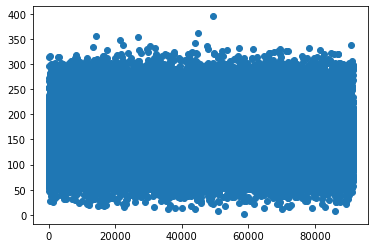

In [79]:
plt.scatter(numbers, abstracts)
plt.show()

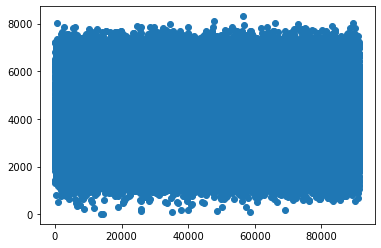

In [80]:
plt.scatter(numbers, texts)
plt.show()

In [81]:
from statistics import mean
print("max length for abstract: ",max(abstracts))
print("max length for text: ",max(texts))
print("min length for abstract: ",min(abstracts))
print("min length for text: ",min(texts))
print("average length for abstract: ",math.floor(mean(abstracts)))
print("average length for text: ",math.floor(mean(texts)))

max length for abstract:  395
max length for text:  8311
min length for abstract:  2
min length for text:  13
average length for abstract:  144
average length for text:  3899


In [82]:
print("50 percentile: ", np.percentile(texts, 50))
print("50 percentile: ", np.percentile(abstracts, 50))
print("0.08 percentile: ", np.percentile(texts, 0.08))
print("0.08 percentile: ", np.percentile(abstracts, 0.08))

50 percentile:  3800.0
50 percentile:  140.0
0.08 percentile:  702.3240000000001
0.08 percentile:  31.0


# RNN Model definition

In [18]:
class Encoder(nn.Module):
    def __init__(self, voc_size, num_layer, hidden_dim, device):
        super(Encoder, self).__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        self.num_layer = num_layer
        
        self.embeddings = nn.Embedding(
            num_embeddings=voc_size,
            embedding_dim=hidden_dim
        )
        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layer,
            bidirectional=False,
            batch_first=True
        )

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layer, batch_size, self.hidden_dim, device=device),
                torch.zeros(self.num_layer, batch_size, self.hidden_dim, device=device))

    def forward(self, input):
        #start = time.time()

        #print(input.shape)
        embedded = self.embeddings(input)
        lengths = (input != 2).sum(1) # pad index = 2
        #print(lengths)
        batch_size = input.shape[0]
        embedded = self.embeddings(input)
        #print("lengths: ",lengths.shape)
#         print(lengths)
#         print("embedded: ",embedded.shape)
#         print("embedded: ",embedded.view(1, 1, -1).shape)
    
#         print("initial_hidden", initial_hidden.shape)
        embedded = torch.nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), 
                                                           batch_first=True,enforce_sorted=False)
#         print("embedded: ",embedded[0].shape)
#         print("embedded: ",embedded[1].shape)
        output, hidden = self.lstm(embedded)
        #print("output: ",output.shape)
        output, lengths = torch.nn.utils.rnn.pad_packed_sequence(output, batch_first=True,padding_value=2)
        lengths = lengths.to(device)
        return output, hidden, lengths

In [19]:
class Decoder(nn.Module):
    def __init__(self, voc_size, num_layer,hidden_dim):
        super(Decoder, self).__init__()
        self.embeddings = nn.Embedding(
            num_embeddings=voc_size,
            embedding_dim=hidden_dim
        )
        self.attention = Attention(hidden_dim,hidden_dim)
        self.lstm = nn.LSTM(
            input_size=hidden_dim*2,
            hidden_size=hidden_dim,
            num_layers=num_layer,
            bidirectional=False,
            batch_first=True
        )
        self.fc = nn.Linear(
            in_features=hidden_dim * 2,
            out_features=voc_size
        )
        self.logsoftmax = nn.LogSoftmax(dim=1)
    

    def forward(self, input, hidden, context, encoder_outputs, lengths): # also add in encoder outputs 
                                                                # to create context
        #start = time.time()
        embedded = self.embeddings(input) # [batch, 256]
        # hidden = [bathc, seq_len, hidden_dim]
        # print(hidden[0])
        #hidden_permute = hidden.permute(0,1) # [1, 512]
        decoder_input = torch.cat((embedded, context), -1).unsqueeze(1) # [batch, 1, 512]
        decoder_output, hidden = self.lstm(decoder_input, hidden)
        decoder_output = decoder_output.squeeze(1)
        
        # mask to block decoder from knowing future sequences/block padding
        max_len = lengths.max().item()
        #print("max len: ", max_len)
        
       
    
        mask = torch.arange(max_len).expand(len(lengths), max_len) < lengths.unsqueeze(1).cpu()
        mask = mask.to(device)
#         print("size: ", len(mask))
#         print("mask 0",mask[0])
#         print("mask0 len",len(mask[0]))
#         print("mask0 = true",torch.sum(mask[0] == True))
#         print("mask1",mask[1])
#         print("mask1 len",len(mask[1]))
#         print("mask1 = true",torch.sum(mask[1] == True))
        attention = self.attention(decoder_output, encoder_outputs, mask).to(device)

        context = attention.unsqueeze(1).bmm(encoder_outputs).squeeze(1)
        #print("context shape: ", context.shape)
        output_context = torch.cat((decoder_output, context), dim=1) # []
        #output_context = torch.nn.functional.relu(output_context)
        
        output_context = self.fc(output_context)
        #print(output[0])
        output = self.logsoftmax(output_context)
        #end = time.time()
        #print("Decoder Time: ",end - start)
#         print("decode output: ",output)
#         print("output: ", output.shape)
        # output is [batch, seq_len, hidden_dim]
        # hidden = 2,2,256 [2, batch, hidden_dim]
        return output, hidden, context, attention
    

In [20]:
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        
#         self.attn_hidden_vector = nn.Linear(encoder_hidden_dim + decoder_hidden_dim, decoder_hidden_dim)
        
#         self.attn_scoring_fn = nn.Linear(decoder_hidden_dim, decoder_hidden_dim, bias=False)
        
        
    def forward(self, hidden, encoder_outputs, mask):
        # hidden = [num_layer, batch size, decoder hidden dim]
        # encoder_outputs [batch, seq_len, hidden_dim]
        seq_len = encoder_outputs.shape[1] # 10000
        batch_size = encoder_outputs.shape[0]
        
        #attention_scores = torch.zeros((batch_size, seq_len), device=device)

        hidden = hidden.repeat(seq_len,1,1)
        #print(hidden.shape)

        encoder_outputs = encoder_outputs.permute(1,0,2)
        #print(encoder_outputs.shape)

        #print("attention score: ", attention_scores.shape)
#         print("hidden atten: ",hidden.shape)
#         print("encoder output: ", encoder_outputs.shape)


        attention_scores = torch.einsum('sbd,sbd->bs',hidden, encoder_outputs) 
        # need to check if can use just lbd, sbd ->bs because hidden repeat don't work if more than 1 layer
        #print("attention_scores: ",attention_scores.shape)

            
        attention_scores[~mask] = -float('inf')
        #print(attention_scores)
        #attention_scores = nn.functional.relu(attention_scores)
        #end = time.time()
        #print("Attention Time: ",end - start)
        attention_scores = nn.functional.softmax(attention_scores, dim=1)
        return attention_scores


In [21]:
class Model(nn.Module):
    def __init__(self, encoder, decoder, hidden_dim):
        super(Model, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.hidden_dim = hidden_dim

    def forward(self, abstract, text):
        #decoder = Decoder(len(abstract_vocab), 512).to(device)
        output, hidden, lengths = self.encoder(text) # [10000, 512] [seq_len, hidden_dim]
        batch_size = output.shape[0]
        
        decoder_hidden = hidden
        context = torch.zeros(batch_size, self.hidden_dim).to(device) # batch, hidden_dim
        decoder_input = torch.LongTensor([0]).repeat(batch_size).to(device)
#         out1 = output[0] # varied
#         out2 = output[1]
#         out3 = output[2]
        done = torch.BoolTensor(batch_size).fill_(False).to(device)
        outputs = []
        words = []
        for t in range(82):
            decoder_output, decoder_hidden, context, attention = self.decoder(decoder_input, 
                                                            decoder_hidden, context, output, lengths)

            outputs.append(decoder_output)

            decoder_input = decoder_output.argmax(1)
           
            words.append(decoder_input)

        sentence = ""
        
        for i in words:
            sentence += abstract_vocab.get_word(i[0].item()) + " "
        print("predict:", sentence)
        sentence = ""
        for i in abstract[0]:
            sentence += abstract_vocab.get_word(i.item()) + " "
        print("actual:", sentence)
        outputs = torch.stack(outputs, 1) # B x T x D
        return outputs

        #input, hidden, context, encoder_outputs
        # squeeze converts the [[]] 3d tensor to 2D, then detach converts it to 1D and item converts to int
    #     _, initial = decode_output.topk(1)
    #     initial = initial.squeeze().detach().item()
    #     start_input = [initial]
    #     decoded_words = [initial]
#         decoded_words = [[]]
#         done = [False for i in range(batch_size)]
#         decoded_loss = torch.Tensor().to(device)
        
#         # attentions = []
#         # repeat until end token, but should limit to less than text length
#         # try keeping the variable length
#         # when calculating loss expand either prediction or original to fit the lengthier target's length
#         # by filling the rest with token for pad

#         for i in range(82):
#             decoder_output, decoder_hidden, context, attention = self.decoder(decoder_input, 
#                                                                   decoder_hidden, context, output, lengths)
            
            
#             #print(decoder_output)

#             # return attention
#             # attentions.append(attention)
#             # teacher forcing here, basically use ground truth values for input
#     #         if random.uniform(0, 1) > 0.5:
#             decoded_loss = torch.cat((decoded_loss, decoder_output.unsqueeze(1)), 1)
#             _, topi = decoder_output.topk(k=1)
#             #print("topi",topi)
#     #         else:
#     #             topi = text[i]

#             decoder_input = decoder_output.argmax(1)
#             #print("deocder output",decoder_input)

#             for j in range(1):
#                 if decoder_input[j].item() == 1:
#                     done[j] = True
#                 if not done[j]:
#                     decoded_words[j].append(decoder_input[j].item())
#                 else:
#                     decoded_words[j].append(2)
# #             start_input = [decoder_input.item()]
#             #do some processing here to convert words into tensor for loss calculation

#         for k in range(1):
#             sentence=""
#             for i in decoded_words[k]:
#                 sentence+= abstract_vocab.get_word(i) + " "
#             print("predict: ",sentence)
#         for i in range(1):
#             sentence=""
#             for i in abstract[i]:
#                 sentence+= abstract_vocab.get_word(i.item()) + " "
#             print("actual: ",sentence)
        #print((decoded_loss))
        
        return decoded_loss

In [22]:
encoder = Encoder(len(text_vocab), num_layer=2, hidden_dim=256, device=device)
encoder = encoder.to(device)
decoder = Decoder(len(abstract_vocab), num_layer=2, hidden_dim=256)
decoder = decoder.to(device)
# abstract, text = next(iter(train_loader))
# abstract = abstract.to(device)
# text = text.to(device)
model = Model(encoder, decoder, 256)
model = model.to(device)
#out1 = model(abstract, text)

# Tasks
~~1 - Complete model definition~~ <br>
~~2 - fix word vocab~~ <br>
~~3 - Define Attention model and combine with Decoder~~ <br>
    ~~1 - Adjust to allow for batch ~~<br>
4 - trace through program to see where it starts to have the same tensor <br>
~~5 - use mask to hide paddings~~ switch on off to see difference<br>
~~6 - Switch from GRU to LSTM~~<br>
~~7 - Add training script to train ~~<br>
 

# Model training

In [56]:
def train(train_loader, valid_loader, model):
    criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # learning rate also affects overfitting
    epoch_size = 150
    loss_points = []
    eval_loss_points = []
    best_loss = 10000

    for epoch in range(epoch_size):
        
        model.train()
        loss_avg = []
        for i, (abstract, text) in enumerate(train_loader):
            # send batch data to device
            abstract = abstract.to(device)
            text = text.to(device)
            
            outputs = model(abstract, text).to(device).permute(0,2,1)
            #print("output",outputs[:,0,:])
#             print(outputs.dtype)
#             print("abstract", abstract[:,0])
#             print(abstract.dtype)

            loss = 0

            loss = criterion(outputs, abstract)
            print(loss.item())

            # Optimise
            del abstract
            del text
            del outputs

            loss_avg.append(loss.item())
            optimizer.zero_grad()
            loss.backward()

           # plot_grad_flow(model.named_parameters())

            del loss
            torch.cuda.empty_cache()
            optimizer.step()

            #print(loss.item())
        current_loss = np.average(loss_avg)
        loss_points.append(current_loss)

        print('Epoch [{}/{}], Loss: {:.4f}'
            .format(epoch+1, epoch_size, current_loss))

        eval_loss_avg = []

        model.eval()
        with torch.no_grad():
            for j, (abstract, text) in enumerate(valid_loader):
                abstract = abstract.to(device)
                text = text.to(device)

                scores = model(abstract, text).permute(0,2,1)
                eval_loss = 0
                
                eval_loss = criterion(scores, abstract)
                print(eval_loss.item())
                eval_loss_avg.append(eval_loss.item())
                del abstract
                del text
                del scores
                del eval_loss
                torch.cuda.empty_cache()

        current_eval_loss = np.average(eval_loss_avg)
        eval_loss_points.append(current_eval_loss)
        if (current_eval_loss < best_loss):
            best_loss = current_eval_loss
            torch.save(model.state_dict(), 'best_decoder.pth')
            print("Best eval loss updated!")

        print('Valid Epoch [{}/{}], Loss: {:.4f}'
            .format(epoch+1, epoch_size, current_eval_loss))
    return loss_points, eval_loss_points
train_loss, eval_loss = train(train_loader, valid_loader, model)

In [55]:
torch.save(model.state_dict(), 'best_decoder20230719.pth')

In [ ]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        print(n)
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            #print(type(p.grad))
            ave_grads.append(torch.mean(torch.abs(p.grad)).cpu())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

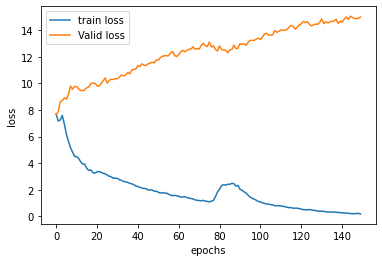

In [57]:
plt.plot(train_loss)
plt.plot(eval_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train loss','Valid loss'])

# Model Evaluation

In [1020]:
import gc
gc.collect()
torch.cuda.empty_cache()

# FastText

## Model for querying

train fasttext model
obtain weight from fasttest
then embedding can load weights

- train 2 fasttext model, 1 for text and another for abstract
- obtain weights for both vocab
- put in encoder and decoder like normal
- https://stackoverflow.com/questions/31440803/how-to-fetch-vectors-for-a-word-list-with-word2vec
- use this to update the vocab class to update ways to fetch words
- to solve querying, use the model and use function to find cosine

In [7]:
import fasttext
model = fasttext.train_unsupervised('data/fil9')
model.save_model("result/fil9.bin")
model = fasttext.load_model("result/fil9.bin")
# EXPECTS TEXT FILE FORMAT WHERE 1 TEXT PER ROW
# IMPORTANT, NEED TO REDESIGN CLEANING PROCESS 

ValueError: data/fil9 cannot be opened for training!

In [ ]:
path = r"\....Downloads\RuchaSawarkar.pdf"
#Using PyPDF2
#importing required modules
import PyPDF4
# creating a pdf file object
pdfFileObj = open(path, 'rb')
#creating a pdf reader object
pdfReader = PyPDF4.PdfFileReader(pdfFileObj)
#printing number of pages in pdf file
print(pdfReader.numPages)
#creating a page object
pageObj = pdfReader.getPage(0)
# extracting text from page
for i in range(pdfReader.numPages):
    pypdf2_text +=pdfReader.getPage(i).extractText()
#closing the pdf file object
pdfFileObj.close()

# Dataset Exploration

In [58]:
def get_df_lengths(df):
    ratio = []
    for i,row in df.iterrows():
        article = len(row["article"].split())
        highlight = len(row["highlights"].split())
        if (i==137538):
            print(row["article"])
            print("---------------------")
            print(row["highlights"])
        ratio.append(highlight/article)
    return ratio

In [59]:
ratio = get_df_lengths(df)

Downton Abbey's famously grim butler, Mr Bates .
---------------------
And now for the good news . . . Following a particularly grim week, here’s a compendium of some of the world’s most comforting headlines: .
Supermodel Smiles On Catwalk .
Jack Russell Dog Welcomes Stranger .
Child At Funfair ‘Delighted’ By Goldfish .
Katie Price Breasts ‘Roughly Same Size As Last Week’ Say Experts .
Teenager Looks Up From Phone, Greets Parent .
Political Pundits Agree To Stop Discussing Hung Parliament For Next Three Months .
Diner Finishes His Curly Kale .
Pensioner Looks Great In Party Hat .
Celebrity Fails To Compare Life To Roller-coaster .
Pet Hamster Repays Child’s Affection .
‘Cheer Up, It May Never Happen’ — Downton’s Mr Bates Enjoys Belly-laugh .
Style Journalist Fails To Employ The Word ‘Iconic’
Sally Bercow Goes Out On Town, Retains Dignity .
Entire Windfarm Operates According To Plan .
Miley Cyrus Feels A Bit Chilly, Opts For Extra Layer .


In [47]:
ratio

[0.18686868686868688,
 0.09693877551020408,
 0.0853960396039604,
 0.09981167608286252,
 0.11551724137931034,
 0.12574850299401197,
 0.03099730458221024,
 0.08695652173913043,
 0.09688013136288999,
 0.06306306306306306,
 0.09338235294117647,
 0.09428129829984544,
 0.04805914972273567,
 0.14903846153846154,
 0.05941845764854614,
 0.12058212058212059,
 0.03619909502262444,
 0.05114029025570145,
 0.14392059553349876,
 0.09248554913294797,
 0.11290322580645161,
 0.06223175965665236,
 0.025252525252525252,
 0.0670807453416149,
 0.07357357357357357,
 0.059931506849315065,
 0.0497335701598579,
 0.04749512036434613,
 0.22916666666666666,
 0.12189616252821671,
 0.10119840213049268,
 0.04323094425483504,
 0.09049773755656108,
 0.022063208109719738,
 0.10561797752808989,
 0.16293929712460065,
 0.058163265306122446,
 0.11014492753623188,
 0.04020979020979021,
 0.13213213213213212,
 0.1079734219269103,
 0.05200945626477541,
 0.07241379310344828,
 0.07616707616707617,
 0.09510869565217392,
 0.1128472

In [50]:
max(ratio)

19.0

In [51]:
ratio.index(max(ratio))

137538

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


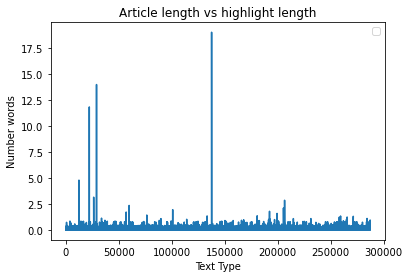

In [48]:
sep = np.arange(len(art_len))

plt.plot(ratio)

plt.xlabel("Text Type")
plt.ylabel("Number words")
plt.title("Article length vs highlight length")
plt.legend()
plt.show()

In [29]:
df.isnull().any()

id            False
article       False
highlights    False
dtype: bool

After exploring, all highlight:article ratio being more than 1.0 means the summary text is producing more text than the original text, this defeats the purpose of the model, therefore all data with a ratio of more than or equal to 1.0 will be omitted.

# Dataset modification/Data Augmentation

In [ ]:
aug_data_transform = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Resize(224), 
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

# Model improvement/Retrain

# Model Finalisation and Evaluation